In [1]:
import numpy as np

import matplotlib.pyplot as plt

from astropy.io import fits
from astropy import stats
from astropy.modeling.models import Gaussian2D, Polynomial2D, Lorentz2D, Moffat2D, PowerLaw1D
from astropy.modeling import fitting, custom_model
from astropy.convolution import Gaussian2DKernel

from photutils.aperture import CircularAperture
from photutils.profiles import RadialProfile

from skimage import restoration

from mmtwfs.wfs import check_wfsdata, wfsfind, Binospec

In [2]:
%load_ext autoreload
%autoreload 2
#%matplotlib widget

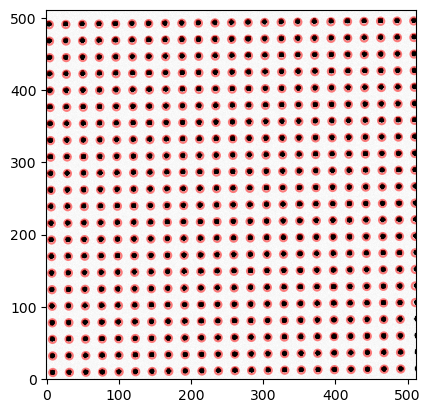

In [3]:
bino = Binospec()

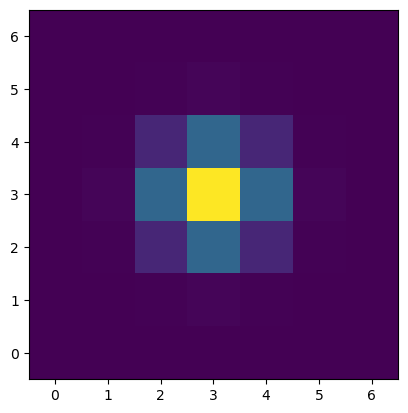

np.float64(0.3526471511743015)

In [13]:
bino.ref_spot_fwhm()
bino_spot_psf = Gaussian2DKernel(bino.ref_spot_fwhm() * stats.gaussian_fwhm_to_sigma)
plt.imshow(bino_spot_psf, origin='lower')
plt.show()
bino_spot_psf.array.max()

In [152]:
spot = fits.open("spot.fits")[0].data

back = np.mean([spot[:2, :].mean(), spot[-2:, :].mean(), spot[:, :2].mean(), spot[:, -2:].mean()])
print(back)
spot -= back
g2d = Gaussian2D(amplitude=spot.max(), x_mean=spot.shape[1]/2, y_mean=spot.shape[0]/2)
l2d = Lorentz2D(amplitude=spot.max(), x_0=spot.shape[1]/2, y_0=spot.shape[0]/2)
m2d = Moffat2D(amplitude=spot.max(), x_0=spot.shape[1]/2, y_0=spot.shape[0]/2)

model = m2d
gmodel = g2d
fitter = fitting.DogBoxLSQFitter()
y, x = np.mgrid[:spot.shape[0], :spot.shape[1]]
fit = fitter(model, x, y, spot)
gfit = fitter(gmodel, x, y, spot)

gsigma = 0.5 * (gfit.x_stddev.value + gfit.y_stddev.value)
#print(sigma)
print(fit.fwhm * 0.153, gsigma * stats.gaussian_sigma_to_fwhm * 0.153)

431479.5846774194
0.7901798849254922 0.8762775734625302


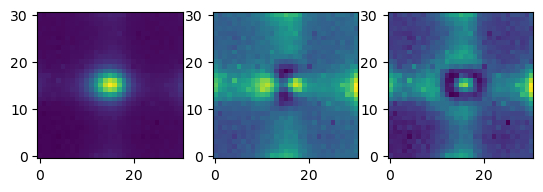

In [153]:
fig, ax = plt.subplots(1, 3)
im1 = ax[0].imshow(spot, origin='lower')
im2 = ax[1].imshow(spot - fit(x, y), origin='lower')
im2 = ax[2].imshow(spot - gfit(x, y), origin='lower')
plt.show()

In [154]:
@custom_model
def spot_profile(r, amplitude=1, a=1):
    return amplitude * np.exp(-a * r**(5/3))

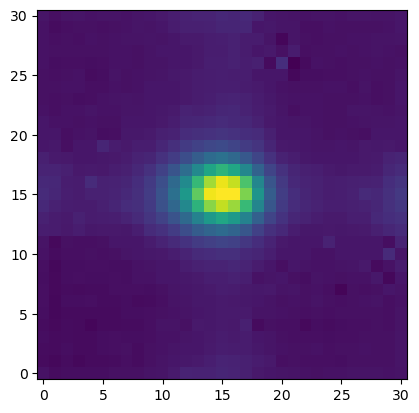

In [155]:
spot_deconvolved = restoration.richardson_lucy(spot/spot.max(), bino_spot_psf.array/bino_spot_psf.array.max(), num_iter=5)
plt.imshow(spot_deconvolved, origin='lower')
plt.show()

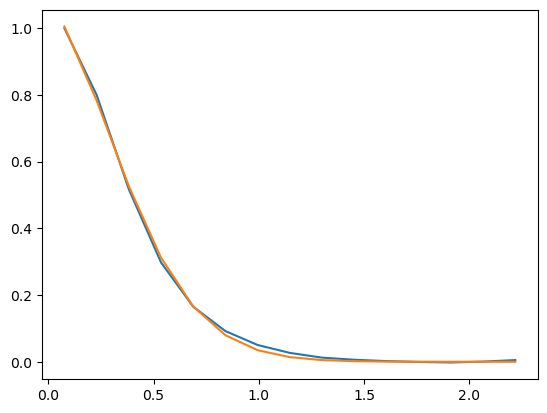

Parameter('amplitude', value=1.0542303755398705) Parameter('a', value=3.44510631049051)


In [156]:
xycen = (spot_deconvolved.shape[1]/2, spot_deconvolved.shape[0]/2)
edge_radii = np.arange(np.max(xycen))
rp = RadialProfile(spot_deconvolved, xycen, edge_radii)
rp.normalize()
prof_model = spot_profile(amplitude=1, a=1)
#prof_model.amplitude.fixed = True
rad_ang = rp.radius * 0.153
prof_fit = fitter(prof_model, rad_ang, rp.profile)
plt.plot(rad_ang, rp.profile)
plt.plot(rad_ang, prof_fit(rad_ang))
plt.show()
print(prof_fit.amplitude, prof_fit.a)

In [157]:
wave = 0.6e-6
refwave = 0.5e-6
r0 = wave / (3.44/prof_fit.a)**0.6
seeing_fwhm = 0.976 * wave / r0
seeing_fwhm = seeing_fwhm * refwave**-0.2 / wave**-0.2
206265 * r0, seeing_fwhm

(np.float64(0.12386919146457646), np.float64(1.0113455213426117))

In [158]:
bino.seeing("binospec", gsigma), bino.seeing("binospec", fit.fwhm * stats.gaussian_fwhm_to_sigma)

((<Quantity 1.0975433 arcsec>, <Quantity 1.0975433 arcsec>),
 (<Quantity 0.9583684 arcsec>, <Quantity 0.9583684 arcsec>))